## 1. Setup Environment

**Before running on Kaggle:**
1. Settings → Accelerator → **GPU T4 x2** (or GPU P100)
2. Add Data → Upload your Gopro dataset folder
   - Or use: Add Data → Search for "gopro image deblurring dataset"

In [1]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("⚠️ WARNING: No GPU detected! Enable GPU in Settings → Accelerator")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB
Number of GPUs: 2


In [2]:
# Check available datasets in Kaggle
import os

print("Available datasets in /kaggle/input/:")
if os.path.exists('/kaggle/input'):
    for item in os.listdir('/kaggle/input'):
        print(f"  - {item}")
else:
    print("Not running on Kaggle - /kaggle/input not found")
    print("If running locally, set DATASET_PATH manually")

Available datasets in /kaggle/input/:
  - gopro-image-deblurring-dataset


In [3]:
# Install required packages
!pip install -q torchmetrics scikit-image pillow matplotlib tqdm

In [4]:
# Create project structure
!mkdir -p models_trained output/training_curves output/comparisons

## 2. Configuration & Utilities

In [ ]:
# Configuration
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchmetrics import PeakSignalNoiseRatio
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 256
BATCH_SIZE = 16  # Kaggle GPUs have good memory
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3

DATASET_PATH = "/kaggle/input/gopro-image-deblurring-dataset/Gopro"

print(f"Device: {DEVICE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Dataset path: {DATASET_PATH}")

Device: cuda
Batch size: 16
Epochs: 50
Dataset path: /kaggle/input/gopro-image-deblurring-dataset/Gopro


## 3. Dataset Class

**📁 Kaggle Dataset Structure:**

Your dataset should be added to Kaggle and accessible at:
```
/kaggle/input/gopro-image-deblurring-dataset/Gopro/
    ├── train/
    │   ├── blur/
    │   └── sharp/
    └── test/
        ├── blur/
        └── sharp/
```

**To add dataset:**
- Click "Add Data" button (top right)
- Search "gopro image deblurring dataset"
- Or upload your own Gopro folder

In [6]:
class GoProDataset(Dataset):
    def __init__(self, split="train", image_size=256, augment=False, dataset_path=None):
        self.image_size = image_size
        self.augment = augment
        self.split = split

        # Use provided path or default Kaggle path
        if dataset_path is None:
            dataset_path = DATASET_PATH

        # Use dataset path
        if split in ["train", "val"]:
            blur_dir = os.path.join(dataset_path, "train", "blur")
            sharp_dir = os.path.join(dataset_path, "train", "sharp")
        else:
            blur_dir = os.path.join(dataset_path, "test", "blur")
            sharp_dir = os.path.join(dataset_path, "test", "sharp")

        self.blur_images = sorted(os.listdir(blur_dir))
        self.sharp_images = sorted(os.listdir(sharp_dir))

        # Split train/val
        if split == "train":
            split_idx = int(len(self.blur_images) * 0.9)
            self.blur_images = self.blur_images[:split_idx]
            self.sharp_images = self.sharp_images[:split_idx]
        elif split == "val":
            split_idx = int(len(self.blur_images) * 0.9)
            self.blur_images = self.blur_images[split_idx:]
            self.sharp_images = self.sharp_images[split_idx:]

        self.blur_dir = blur_dir
        self.sharp_dir = sharp_dir

        # Transforms
        if split == "train":
            self.transform = transforms.Compose([
                transforms.RandomCrop(image_size),
                transforms.RandomHorizontalFlip() if augment else transforms.Lambda(lambda x: x),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.CenterCrop(image_size),
                transforms.ToTensor()
            ])

        print(f"[{split.upper()}] Dataset loaded: {len(self.blur_images)} images")

    def __len__(self):
        return len(self.blur_images)

    def __getitem__(self, idx):
        blur_path = os.path.join(self.blur_dir, self.blur_images[idx])
        sharp_path = os.path.join(self.sharp_dir, self.sharp_images[idx])

        blur_img = Image.open(blur_path).convert('RGB')
        sharp_img = Image.open(sharp_path).convert('RGB')

        # Apply same random transform to both
        seed = np.random.randint(2147483647)
        np.random.seed(seed)
        torch.manual_seed(seed)
        blur_tensor = self.transform(blur_img)

        np.random.seed(seed)
        torch.manual_seed(seed)
        sharp_tensor = self.transform(sharp_img)

        return blur_tensor, sharp_tensor

## 4. Model Architectures

In [ ]:
class DeblurringSimple(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, kernel_size=5, padding=2, bias=False):
        super().__init__()
        self.convolution = nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, padding=padding, bias=bias)

    def forward(self, x):
        return self.convolution(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super().__init__()
        features = init_features

        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block((features * 8) * 2, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block((features * 4) * 2, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block((features * 2) * 2, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)


class DeblurCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.conv5(out)
        out += residual
        return out


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out


class DeblurGANv2Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, base, 3, 1, 1)
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(base) for _ in range(8)]
        )
        self.conv2 = nn.Conv2d(base, out_channels, 3, 1, 1)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.res_blocks(x)
        x = self.conv2(x)
        return torch.sigmoid(x + residual)


print("✅ Models defined successfully")

✅ Models defined successfully


## 5. Training Functions

In [8]:
def train_epoch(loader, model, optimizer, loss_fn, loop):
    epoch_loss = 0.0
    for data_blur, data_sharp in loop:
        data_blur = data_blur.to(DEVICE)
        data_sharp = data_sharp.to(DEVICE)

        outputs = model(data_blur)
        loss = loss_fn(outputs, data_sharp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())

    return epoch_loss / len(loader)


def validate(val_loader, model, loss_fn, eval_metric):
    model.eval()
    loop = tqdm(val_loader, desc="Validation", leave=True)
    epoch_loss = 0.0
    psnr_sum = 0.0
    with torch.no_grad():
        for data_blur, data_sharp in loop:
            data_blur = data_blur.to(DEVICE)
            data_sharp = data_sharp.to(DEVICE)

            outputs = model(data_blur)
            loss = loss_fn(outputs, data_sharp)

            epoch_loss += loss.item()
            psnr_sum += eval_metric(outputs, data_sharp).item()
            loop.set_postfix(val_loss=loss.item())

    avg_val_loss = epoch_loss / len(val_loader)
    avg_psnr = psnr_sum / len(val_loader)
    return avg_val_loss, avg_psnr


def test(test_loader, model, loss_fn, eval_metric):
    print("\nRunning Final Test Evaluation...")
    model.eval()
    loop = tqdm(test_loader, desc="Testing", leave=True)
    test_loss = 0.0
    psnr_sum = 0.0

    with torch.no_grad():
        for data_blur, data_sharp in loop:
            data_blur = data_blur.to(DEVICE)
            data_sharp = data_sharp.to(DEVICE)

            outputs = model(data_blur)
            loss = loss_fn(outputs, data_sharp)

            test_loss += loss.item()
            psnr_sum += eval_metric(outputs, data_sharp).item()

    avg_test_loss = test_loss / len(test_loader)
    avg_psnr = psnr_sum / len(test_loader)

    print(f"TEST RESULTS:")
    print(f"  Average Test Loss: {avg_test_loss:.4f}")
    print(f"  Average Test PSNR: {avg_psnr:.2f} dB")
    return avg_psnr


def plot_training_curves(train_losses, val_losses, val_psnrs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Training & Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(val_psnrs, label='Val PSNR', marker='o', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('PSNR (dB)')
    ax2.set_title(f'{model_name} - Validation PSNR')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'output/training_curves/{model_name}_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


print("✅ Training functions defined")

✅ Training functions defined


## 6. Main Training Loop

In [9]:
def train_model(model, model_name, train_loader, val_loader, test_loader):
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
    best_val_metric = 0.0

    train_losses = []
    val_losses = []
    val_psnrs = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        print()
        loop = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{NUM_EPOCHS}]", leave=True)

        avg_train_loss = train_epoch(train_loader, model, optimizer, loss_fn, loop)
        val_loss, val_metric = validate(val_loader, model, loss_fn, psnr_metric)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_psnrs.append(val_metric)

        print(f"  Average Train Loss: {avg_train_loss:.4f}")
        print(f"  Average Val Loss: {val_loss:.4f}")
        print(f"  Val PSNR: {val_metric:.2f} dB")

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            save_path = f'models_trained/{model_name}_best.pth'
            torch.save(model.state_dict(), save_path)
            print(f"    ✅ New best PSNR! Saved to {save_path}")

    print("\n✅ Training completed.")

    # Plot training curves
    plot_training_curves(train_losses, val_losses, val_psnrs, model_name)

    # Load best model and test
    model.load_state_dict(torch.load(f'models_trained/{model_name}_best.pth'))
    print("\nLoaded best model for testing.")

    test_psnr = test(test_loader, model, loss_fn, psnr_metric)

    return {
        'model_name': model_name,
        'best_val_psnr': best_val_metric,
        'test_psnr': test_psnr,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_psnrs': val_psnrs
    }


print("✅ Main training function defined")

✅ Main training function defined


## 7. Load Dataset

In [10]:
print("Loading datasets...")

train_dataset = GoProDataset(split="train", image_size=IMAGE_SIZE, augment=True)
val_dataset = GoProDataset(split="val", image_size=IMAGE_SIZE, augment=False)
test_dataset = GoProDataset(split="test", image_size=IMAGE_SIZE, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✅ Datasets loaded successfully!")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Loading datasets...
[TRAIN] Dataset loaded: 1892 images
[VAL] Dataset loaded: 211 images
[TEST] Dataset loaded: 1111 images

✅ Datasets loaded successfully!
Train: 1892 | Val: 211 | Test: 1111


## 8. Train All Models


Training deblurring_simple



/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0149
  Average Val Loss: 0.0055
  Val PSNR: 22.91 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [2/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200><function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0055
  Average Val Loss: 0.0047
  Val PSNR: 23.62 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [3/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0044
  Val PSNR: 23.94 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [4/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0048
  Average Val Loss: 0.0043
  Val PSNR: 24.14 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [5/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0046
  Average Val Loss: 0.0041
  Val PSNR: 24.33 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [6/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0047
  Average Val Loss: 0.0040
  Val PSNR: 24.49 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [7/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^^if w.is_alive():
 ^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^  ^^  ^ ^ ^ ^ ^^^
^  File "/

  Average Train Loss: 0.0045
  Average Val Loss: 0.0039
  Val PSNR: 24.60 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [8/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200><function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     if w.is_alive(): 
Exception ignored in:   Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200> <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>  
  
Traceback (most recent call l

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0038
  Val PSNR: 24.70 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [9/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0043
  Average Val Loss: 0.0037
  Val PSNR: 24.79 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [10/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0043
  Average Val Loss: 0.0037
  Val PSNR: 24.88 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [11/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0036
  Val PSNR: 24.91 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [12/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0036
  Val PSNR: 24.98 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [13/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^^if w.is_alive():^
^ ^ ^^  ^ ^^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^  ^^ ^ ^ ^ ^   ^ 
^  File "/us

  Average Train Loss: 0.0040
  Average Val Loss: 0.0036
  Val PSNR: 24.97 dB



Epoch [14/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200><function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

^^    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

     Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200> Exception ignored in: 

 Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0035
  Val PSNR: 25.04 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [15/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.06 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [16/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.08 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [17/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.09 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [18/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0035
  Val PSNR: 25.06 dB



Epoch [19/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()  
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
 ^    ^if w.is_alive():^^
^  ^ ^ ^  ^ ^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  ^ ^  ^
     File "/usr/l

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.10 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [20/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    if w.is_alive():

           Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
 Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0035
  Val PSNR: 25.13 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [21/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.12 dB



Epoch [22/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0035
  Val PSNR: 25.13 dB



Epoch [23/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.15 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [24/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.16 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [25/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

       self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive(): 
     ^^ ^  ^^ ^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^
   File "/usr/lib/pytho

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.13 dB



Epoch [26/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200><function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():
if w.is_alive():Exception ignored in: 
  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>   
 Traceback (most recent call last):
  Exception ignored in:     File "/usr/local/lib/python3.12/dist-packages/torch/utils/d

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.14 dB



Epoch [27/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0034
  Val PSNR: 25.17 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [28/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.17 dB



Epoch [29/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.14 dB



Epoch [30/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.17 dB



Epoch [31/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

       self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       ^if w.is_alive():^^
 ^ ^ ^ ^  ^ ^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^^ ^   ^ 
  File "/usr/lib/

  Average Train Loss: 0.0039
  Average Val Loss: 0.0034
  Val PSNR: 25.18 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [32/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
       Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
^ Traceback (most recent call last):
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.18 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [33/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [34/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [35/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0034
  Val PSNR: 25.17 dB



Epoch [36/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB



Epoch [37/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():    
  self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
 ^ ^^ ^ ^ ^ ^ ^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ 
   File "/usr/lib/pyth

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [38/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200><function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()
^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     if w.is_alive(): 
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>  
   Traceback (most recent call last):
 Exception ignored in:    File "/usr/local/lib/python3.12/dist-packages/torch/utils

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB



Epoch [39/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.18 dB



Epoch [40/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0034
  Val PSNR: 25.18 dB



Epoch [41/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB



Epoch [42/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB



Epoch [43/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():  
       ^ ^^ ^ ^^^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^^ 
   File "/usr/lib/py

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.16 dB



Epoch [44/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>    
Traceback (most recent call last):
self._shutdown_workers()    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    self._shutdown_workers()
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():
         ^ ^ ^Exception ignored in: ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/datal

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0034
  Val PSNR: 25.20 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [45/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0035
  Val PSNR: 25.18 dB



Epoch [46/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0034
  Val PSNR: 25.20 dB



Epoch [47/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.18 dB



Epoch [48/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.19 dB



Epoch [49/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
 
            ^   ^ ^ ^^^^^^^^^^^^^^^^^^^^
^

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.21 dB
    ✅ New best PSNR! Saved to models_trained/deblurring_simple_best.pth



Epoch [50/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200><function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive(): 
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
  Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", l

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.11 dB

✅ Training completed.


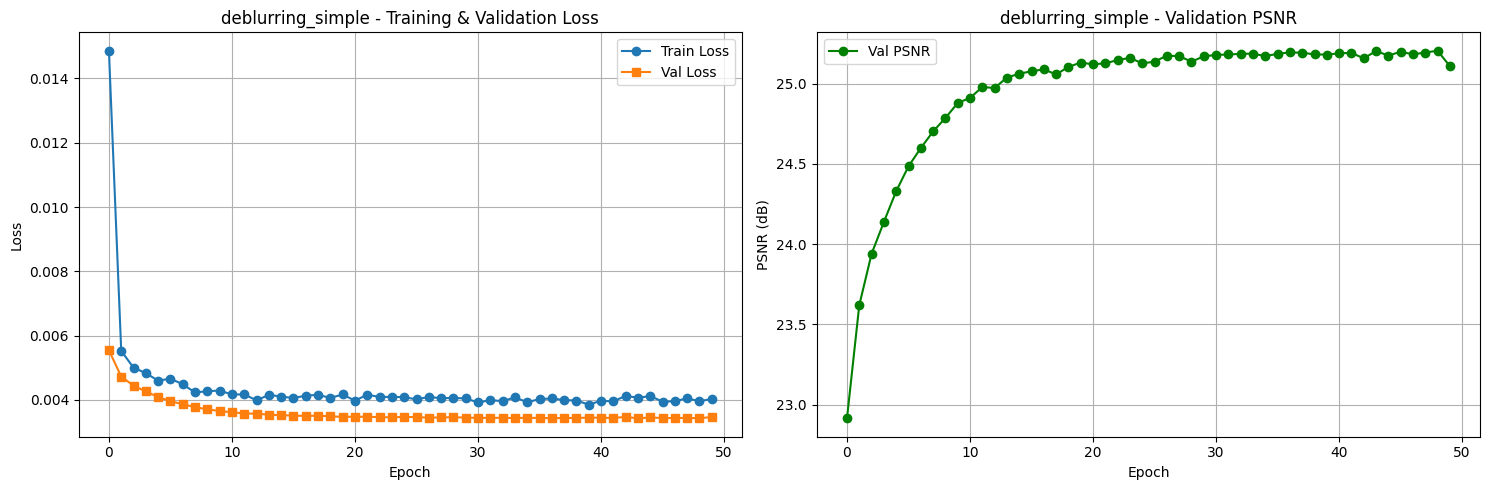


Loaded best model for testing.

Running Final Test Evaluation...


Testing:   0%|          | 0/70 [00:00<?, ?it/s]

TEST RESULTS:
  Average Test Loss: 0.0047
  Average Test PSNR: 23.80 dB

Training unet



Epoch [1/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0319
  Average Val Loss: 0.0076
  Val PSNR: 22.09 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [2/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0070
  Average Val Loss: 0.0064
  Val PSNR: 22.72 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [3/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
self._shutdown_workers()       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    self._shutdown_workers()^

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process' 
           ^ ^ ^ ^

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0064
  Average Val Loss: 0.0040
  Val PSNR: 24.39 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [4/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0064
  Average Val Loss: 0.0047
  Val PSNR: 23.61 dB



Epoch [5/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0061
  Average Val Loss: 0.0037
  Val PSNR: 24.75 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [6/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0057
  Average Val Loss: 0.0039
  Val PSNR: 24.45 dB



Epoch [7/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0056
  Average Val Loss: 0.0046
  Val PSNR: 23.74 dB



Epoch [8/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0062
  Average Val Loss: 0.0037
  Val PSNR: 24.64 dB



Epoch [9/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200> 
  Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    self._shutdown_workers()^^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^^
 ^^  
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
    ^ ^ ^ ^^ ^ ^  ^ ^ ^^^^^
^  File "/

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0060
  Average Val Loss: 0.0036
  Val PSNR: 24.96 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [10/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0057
  Average Val Loss: 0.0036
  Val PSNR: 24.88 dB



Epoch [11/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0058
  Average Val Loss: 0.0040
  Val PSNR: 24.21 dB



Epoch [12/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0058
  Average Val Loss: 0.0036
  Val PSNR: 24.91 dB



Epoch [13/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0056
  Average Val Loss: 0.0036
  Val PSNR: 24.94 dB



Epoch [14/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0053
  Average Val Loss: 0.0038
  Val PSNR: 24.62 dB



Epoch [15/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^^
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^
AssertionError:     c

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0056
  Average Val Loss: 0.0035
  Val PSNR: 25.07 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [16/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0054
  Average Val Loss: 0.0038
  Val PSNR: 24.66 dB



Epoch [17/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0053
  Average Val Loss: 0.0038
  Val PSNR: 24.64 dB



Epoch [18/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0054
  Average Val Loss: 0.0046
  Val PSNR: 23.55 dB



Epoch [19/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0056
  Average Val Loss: 0.0041
  Val PSNR: 24.21 dB



Epoch [20/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0053
  Average Val Loss: 0.0039
  Val PSNR: 24.41 dB



Epoch [21/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():
self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
  ^ ^   ^  ^^^^^^^^^^^^^^^^
^^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0034
  Val PSNR: 25.20 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [22/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0053
  Average Val Loss: 0.0044
  Val PSNR: 23.84 dB



Epoch [23/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0053
  Average Val Loss: 0.0034
  Val PSNR: 25.22 dB
    ✅ New best PSNR! Saved to models_trained/unet_best.pth



Epoch [24/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0055
  Average Val Loss: 0.0036
  Val PSNR: 24.92 dB



Epoch [25/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0052
  Average Val Loss: 0.0035
  Val PSNR: 25.07 dB



Epoch [26/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0055
  Average Val Loss: 0.0037
  Val PSNR: 24.72 dB



Epoch [27/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^^self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    
if w.is_alive():  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      assert self._parent_pid == os.getpid(), 'can only test a child process' 
        ^ ^^ ^^  ^ ^ ^ ^^^^^^^^
  File "

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
 if w.is_alive(): 
        ^ ^ ^ ^ ^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^
   File "/usr/lib/pyt

  Average Train Loss: 0.0055
  Average Val Loss: 0.0040
  Val PSNR: 24.36 dB



Epoch [28/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0053
  Average Val Loss: 0.0036
  Val PSNR: 24.87 dB



Epoch [29/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0036
  Val PSNR: 24.85 dB



Epoch [30/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0052
  Average Val Loss: 0.0035
  Val PSNR: 25.01 dB



Epoch [31/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0048
  Average Val Loss: 0.0055
  Val PSNR: 22.71 dB



Epoch [32/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0053
  Average Val Loss: 0.0038
  Val PSNR: 24.51 dB



Epoch [33/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      ^if w.is_alive():
^^  ^^  ^^ ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
 ^ ^
   File "/usr/lib/py

  Average Train Loss: 0.0056
  Average Val Loss: 0.0041
  Val PSNR: 24.25 dB



Epoch [34/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0057
  Average Val Loss: 0.0035
  Val PSNR: 25.05 dB



Epoch [35/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0051
  Average Val Loss: 0.0035
  Val PSNR: 24.97 dB



Epoch [36/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0052
  Average Val Loss: 0.0050
  Val PSNR: 23.10 dB



Epoch [37/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0034
  Val PSNR: 25.12 dB



Epoch [38/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0052
  Average Val Loss: 0.0035
  Val PSNR: 25.13 dB



Epoch [39/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():
     self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
   ^  ^^ ^^  ^ ^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

  Average Train Loss: 0.0053
  Average Val Loss: 0.0035
  Val PSNR: 25.03 dB



Epoch [40/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0038
  Val PSNR: 24.62 dB



Epoch [41/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0035
  Val PSNR: 25.04 dB



Epoch [42/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0048
  Average Val Loss: 0.0039
  Val PSNR: 24.45 dB



Epoch [43/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0049
  Average Val Loss: 0.0039
  Val PSNR: 24.51 dB



Epoch [44/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0046
  Average Val Loss: 0.0041
  Val PSNR: 24.18 dB



Epoch [45/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
if w.is_alive():Traceback (most recent call last):

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
         self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
 ^ ^^ ^ ^ ^ ^ ^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^^ ^ ^ ^ ^  ^   
  File "/usr/

  Average Train Loss: 0.0048
  Average Val Loss: 0.0034
  Val PSNR: 25.16 dB



Epoch [46/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0048
  Average Val Loss: 0.0040
  Val PSNR: 24.32 dB



Epoch [47/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0052
  Average Val Loss: 0.0036
  Val PSNR: 24.96 dB



Epoch [48/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0049
  Average Val Loss: 0.0050
  Val PSNR: 23.13 dB



Epoch [49/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0049
  Average Val Loss: 0.0040
  Val PSNR: 24.37 dB



Epoch [50/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0046
  Average Val Loss: 0.0035
  Val PSNR: 25.08 dB

✅ Training completed.


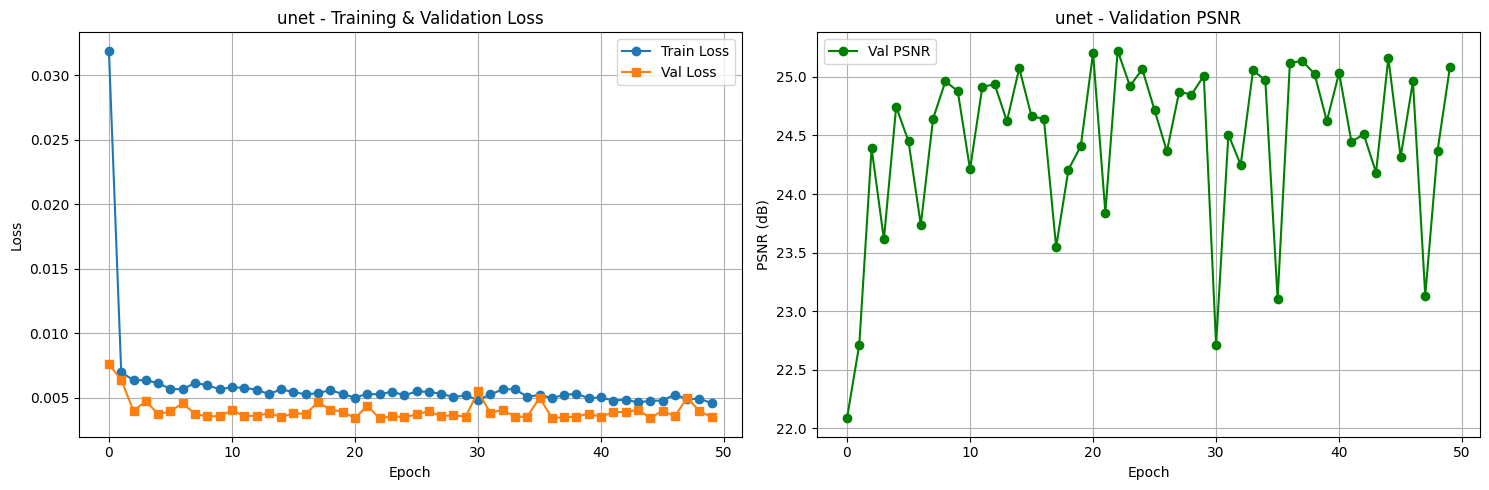


Loaded best model for testing.

Running Final Test Evaluation...


Testing:   0%|          | 0/70 [00:00<?, ?it/s]

TEST RESULTS:
  Average Test Loss: 0.0046
  Average Test PSNR: 23.84 dB

Training deblur_cnn



Epoch [1/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0033
  Val PSNR: 25.35 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [2/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0038
  Average Val Loss: 0.0033
  Val PSNR: 25.36 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [3/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0033
  Val PSNR: 25.45 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [4/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0033
  Val PSNR: 25.46 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [5/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

  Average Train Loss: 0.0037
  Average Val Loss: 0.0033
  Val PSNR: 25.36 dB



Epoch [6/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.51 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [7/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.52 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [8/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0038
  Average Val Loss: 0.0034
  Val PSNR: 25.31 dB



Epoch [9/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.55 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [10/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0038
  Average Val Loss: 0.0033
  Val PSNR: 25.41 dB



Epoch [11/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():
 self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():  
  ^ ^  ^^ ^ ^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^
  File "/usr/lib/pytho

  Average Train Loss: 0.0038
  Average Val Loss: 0.0032
  Val PSNR: 25.53 dB



Epoch [12/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0038
  Average Val Loss: 0.0032
  Val PSNR: 25.51 dB



Epoch [13/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.57 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [14/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.52 dB



Epoch [15/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.59 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [16/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.51 dB



Epoch [17/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
    ^^ ^^ ^ ^ ^ ^^^^

  Average Train Loss: 0.0038
  Average Val Loss: 0.0032
  Val PSNR: 25.59 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [18/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.58 dB



Epoch [19/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.57 dB



Epoch [20/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.59 dB



Epoch [21/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.57 dB



Epoch [22/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.63 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [23/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200> 
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():^
^ ^  ^ ^ ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^^ ^ ^ ^  ^  ^ ^  ^^^^^
^  File "

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.56 dB



Epoch [24/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.59 dB



Epoch [25/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.59 dB



Epoch [26/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.58 dB



Epoch [27/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.59 dB



Epoch [28/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.58 dB



Epoch [29/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
            ^   ^^^^^^^^^^^^^^^^^
^  Fil

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.64 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [30/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.58 dB



Epoch [31/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.62 dB



Epoch [32/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0037
  Average Val Loss: 0.0032
  Val PSNR: 25.54 dB



Epoch [33/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.54 dB



Epoch [34/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.61 dB



Epoch [35/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():

   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
            ^ ^  ^^^^^^^^^^^^^^^^^^^^^^^

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.59 dB



Epoch [36/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.64 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [37/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.64 dB



Epoch [38/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.60 dB



Epoch [39/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.63 dB



Epoch [40/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.62 dB



Epoch [41/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

     if w.is_alive():    
    ^ ^  ^^  ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^
    File "/usr/lib/pyth

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.57 dB



Epoch [42/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.63 dB



Epoch [43/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.64 dB



Epoch [44/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0032
  Val PSNR: 25.64 dB



Epoch [45/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.66 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [46/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.64 dB



Epoch [47/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Average Train Loss: 0.0036
  Average Val Loss: 0.0032
  Val PSNR: 25.63 dB



Epoch [48/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0034
  Average Val Loss: 0.0031
  Val PSNR: 25.65 dB



Epoch [49/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0031
  Val PSNR: 25.67 dB
    ✅ New best PSNR! Saved to models_trained/deblur_cnn_best.pth



Epoch [50/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0035
  Average Val Loss: 0.0031
  Val PSNR: 25.65 dB

✅ Training completed.


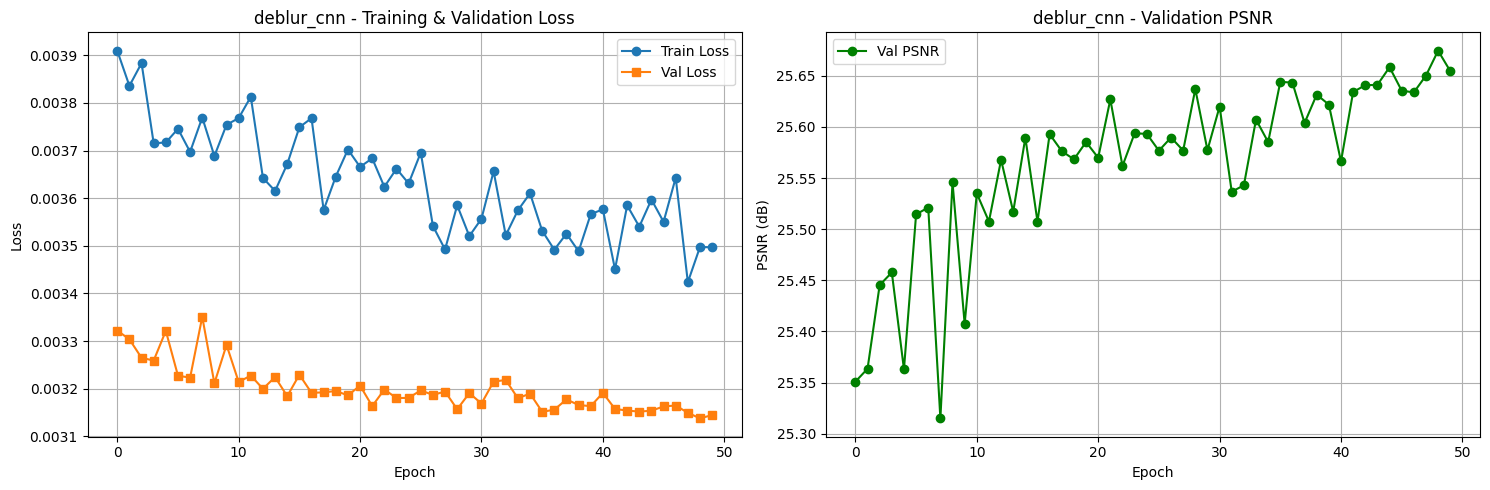


Loaded best model for testing.

Running Final Test Evaluation...


Testing:   0%|          | 0/70 [00:00<?, ?it/s]

TEST RESULTS:
  Average Test Loss: 0.0042
  Average Test PSNR: 24.40 dB

Training deblurganv2



Epoch [1/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0084
  Average Val Loss: 0.0074
  Val PSNR: 21.39 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [2/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0061
  Average Val Loss: 0.0041
  Val PSNR: 24.10 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [3/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0054
  Average Val Loss: 0.0044
  Val PSNR: 23.84 dB



Epoch [4/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0056
  Average Val Loss: 0.0038
  Val PSNR: 24.62 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [5/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0036
  Val PSNR: 24.94 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [6/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0054
  Val PSNR: 22.76 dB



Epoch [7/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
         ^^  ^  ^ ^^^ ^ ^^^^^^^^^
^  Fil

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0054
  Average Val Loss: 0.0045
  Val PSNR: 23.67 dB



Epoch [8/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0048
  Average Val Loss: 0.0037
  Val PSNR: 24.84 dB



Epoch [9/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0048
  Average Val Loss: 0.0035
  Val PSNR: 25.04 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [10/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0046
  Average Val Loss: 0.0039
  Val PSNR: 24.48 dB



Epoch [11/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0050
  Average Val Loss: 0.0036
  Val PSNR: 24.89 dB



Epoch [12/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0044
  Average Val Loss: 0.0038
  Val PSNR: 24.65 dB



Epoch [13/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>  
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
        ^ ^^^^^^^^^^^^^^^^^^^^^^^

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0044
  Average Val Loss: 0.0035
  Val PSNR: 25.15 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [14/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0044
  Average Val Loss: 0.0037
  Val PSNR: 24.83 dB



Epoch [15/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0043
  Average Val Loss: 0.0037
  Val PSNR: 24.73 dB



Epoch [16/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0044
  Val PSNR: 23.74 dB



Epoch [17/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0036
  Val PSNR: 24.96 dB



Epoch [18/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0043
  Average Val Loss: 0.0037
  Val PSNR: 24.81 dB



Epoch [19/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    c

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0044
  Val PSNR: 23.86 dB



Epoch [20/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0037
  Val PSNR: 24.84 dB



Epoch [21/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0034
  Val PSNR: 25.18 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [22/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0035
  Val PSNR: 25.13 dB



Epoch [23/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0043
  Val PSNR: 24.00 dB



Epoch [24/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 24.97 dB



Epoch [25/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

       if w.is_alive(): 
             ^^ ^^^^^^^^^^^^^^^^^^^^^^^

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0052
  Val PSNR: 23.02 dB



Epoch [26/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.22 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [27/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.32 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [28/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.15 dB



Epoch [29/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0036
  Val PSNR: 24.92 dB



Epoch [30/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0035
  Val PSNR: 25.14 dB



Epoch [31/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
   ^^ ^^ ^  ^^ ^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^
    File "/usr/lib/pyt

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0034
  Val PSNR: 25.28 dB



Epoch [32/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.11 dB



Epoch [33/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0042
  Average Val Loss: 0.0035
  Val PSNR: 25.01 dB



Epoch [34/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0034
  Val PSNR: 25.28 dB



Epoch [35/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0040
  Val PSNR: 24.19 dB



Epoch [36/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.02 dB



Epoch [37/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == os.getpid(), 'can only test a child process'  
         ^ ^^ ^ ^ ^ ^^ ^^^^^^^  File "/u

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0034
  Val PSNR: 25.29 dB



Epoch [38/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0043
  Average Val Loss: 0.0041
  Val PSNR: 24.22 dB



Epoch [39/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0044
  Average Val Loss: 0.0035
  Val PSNR: 25.14 dB



Epoch [40/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0034
  Val PSNR: 25.21 dB



Epoch [41/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0041
  Average Val Loss: 0.0034
  Val PSNR: 25.26 dB



Epoch [42/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0035
  Val PSNR: 25.12 dB



Epoch [43/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>    assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive(): 
       ^ ^  ^^^^^^^^^^^^^^^^^^^^^^^

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200> 
 Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^: self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^^if w.is_alive():^^

   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
   ^  ^ ^  ^^ ^^^ ^ ^ ^ ^^^
^^  File

  Average Train Loss: 0.0039
  Average Val Loss: 0.0034
  Val PSNR: 25.21 dB



Epoch [44/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0040
  Average Val Loss: 0.0035
  Val PSNR: 25.14 dB



Epoch [45/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0038
  Average Val Loss: 0.0034
  Val PSNR: 25.30 dB



Epoch [46/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0035
  Val PSNR: 25.00 dB



Epoch [47/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0033
  Val PSNR: 25.30 dB



Epoch [48/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0038
  Average Val Loss: 0.0035
  Val PSNR: 25.11 dB



Epoch [49/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>^
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d7f60b8e200>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/pytho

  Average Train Loss: 0.0038
  Average Val Loss: 0.0034
  Val PSNR: 25.34 dB
    ✅ New best PSNR! Saved to models_trained/deblurganv2_best.pth



Epoch [50/50]:   0%|          | 0/119 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

  Average Train Loss: 0.0039
  Average Val Loss: 0.0040
  Val PSNR: 24.45 dB

✅ Training completed.


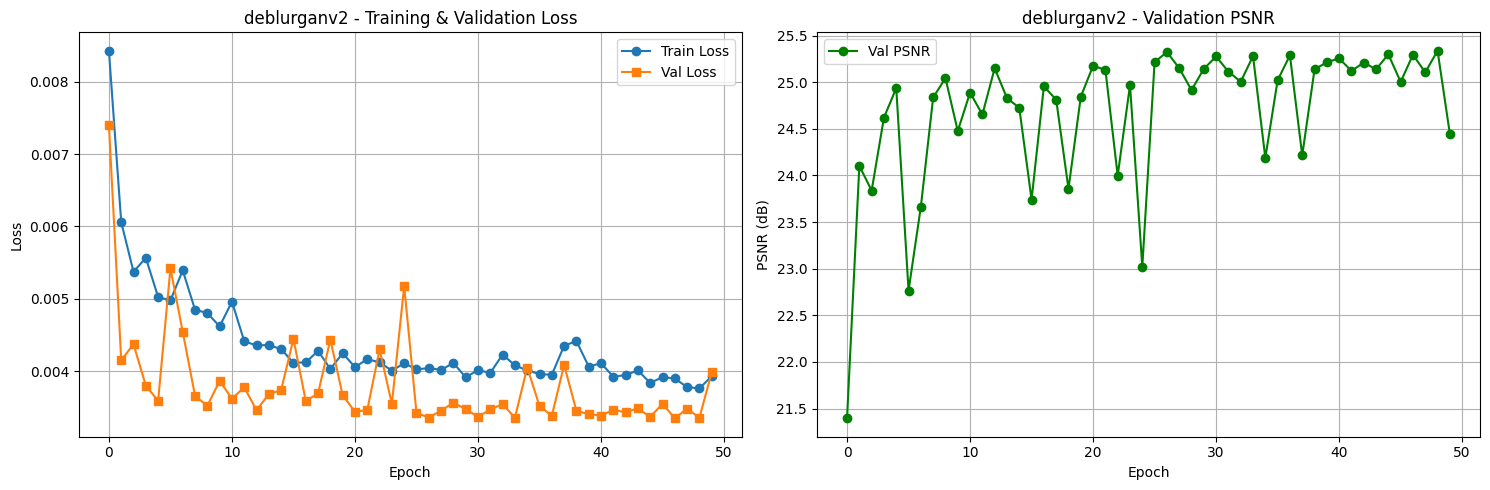


Loaded best model for testing.

Running Final Test Evaluation...


Testing:   0%|          | 0/70 [00:00<?, ?it/s]

TEST RESULTS:
  Average Test Loss: 0.0045
  Average Test PSNR: 23.97 dB

ALL TRAINING COMPLETED!


In [11]:
# Define models to train
models_config = [
    ("deblurring_simple", DeblurringSimple()),
    ("unet", UNet()),
    ("deblur_cnn", DeblurCNN()),
    ("deblurganv2", DeblurGANv2Generator())
]

results = []

for model_name, model in models_config:
    model = model.to(DEVICE)
    result = train_model(model, model_name, train_loader, val_loader, test_loader)
    results.append(result)

    # Free up memory
    del model
    torch.cuda.empty_cache()

print("\n" + "="*60)
print("ALL TRAINING COMPLETED!")
print("="*60)

## 9. Results Summary

In [12]:
# Print summary table
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"{'Model':<20} | {'Best Val PSNR':<15} | {'Test PSNR':<15}")
print("-"*70)

for result in results:
    print(f"{result['model_name']:<20} | {result['best_val_psnr']:>13.2f} dB | {result['test_psnr']:>13.2f} dB")

print("="*70)

# Find best model
best_result = max(results, key=lambda x: x['test_psnr'])
print(f"\n🏆 Best Model: {best_result['model_name']} with Test PSNR: {best_result['test_psnr']:.2f} dB")


FINAL RESULTS SUMMARY
Model                | Best Val PSNR   | Test PSNR      
----------------------------------------------------------------------
deblurring_simple    |         25.21 dB |         23.80 dB
unet                 |         25.22 dB |         23.84 dB
deblur_cnn           |         25.67 dB |         24.40 dB
deblurganv2          |         25.34 dB |         23.97 dB

🏆 Best Model: deblur_cnn with Test PSNR: 24.40 dB


## 10. Save Results

**On Kaggle:**
- All files in `/kaggle/working/` are automatically saved
- Click "Save Version" (top right) to save the notebook with outputs
- Download files from the Output section after completion

In [13]:
# Package results for download
!zip -r trained_models.zip models_trained/ output/

print("\n✅ Results packaged as 'trained_models.zip'")
print("\nOn Kaggle:")
print("1. Click 'Save Version' (top right)")
print("2. After completion, go to the Output tab")
print("3. Download 'trained_models.zip' from there")
print("\nAll files in /kaggle/working/ are automatically saved!")

  adding: models_trained/ (stored 0%)
  adding: models_trained/deblurring_simple_best.pth (deflated 42%)
  adding: models_trained/deblur_cnn_best.pth (deflated 7%)
  adding: models_trained/deblurganv2_best.pth (deflated 8%)
  adding: models_trained/unet_best.pth (deflated 8%)
  adding: output/ (stored 0%)
  adding: output/training_curves/ (stored 0%)
  adding: output/training_curves/deblur_cnn_curves.png (deflated 11%)
  adding: output/training_curves/deblurganv2_curves.png (deflated 12%)
  adding: output/training_curves/unet_curves.png (deflated 14%)
  adding: output/training_curves/deblurring_simple_curves.png (deflated 18%)
  adding: output/comparisons/ (stored 0%)

✅ Results packaged as 'trained_models.zip'

On Kaggle:
1. Click 'Save Version' (top right)
2. After completion, go to the Output tab
3. Download 'trained_models.zip' from there

All files in /kaggle/working/ are automatically saved!


## 11. Visualize Sample Results (Optional)

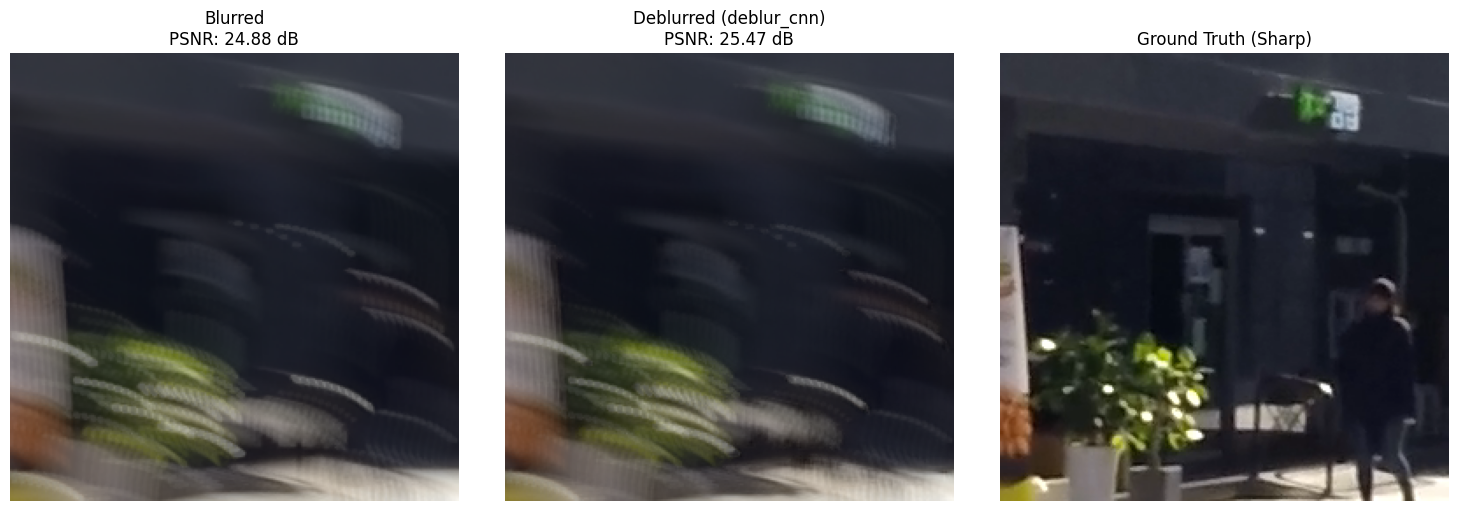

In [14]:
# Visualize deblurring on a test image
def visualize_deblurring(model_name, test_loader):
    # Load model
    if model_name == "unet":
        model = UNet().to(DEVICE)
    elif model_name == "deblur_cnn":
        model = DeblurCNN().to(DEVICE)
    elif model_name == "deblurganv2":
        model = DeblurGANv2Generator().to(DEVICE)
    else:
        model = DeblurringSimple().to(DEVICE)

    model.load_state_dict(torch.load(f'models_trained/{model_name}_best.pth'))
    model.eval()

    # Get a test sample
    blur, sharp = next(iter(test_loader))
    blur, sharp = blur.to(DEVICE), sharp.to(DEVICE)

    with torch.no_grad():
        deblurred = model(blur)

    # Calculate PSNR
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
    psnr_input = psnr_metric(blur, sharp).item()
    psnr_output = psnr_metric(deblurred, sharp).item()

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Convert to numpy for plotting
    blur_np = blur[0].cpu().permute(1, 2, 0).numpy()
    deblurred_np = deblurred[0].cpu().permute(1, 2, 0).numpy()
    sharp_np = sharp[0].cpu().permute(1, 2, 0).numpy()

    axes[0].imshow(np.clip(blur_np, 0, 1))
    axes[0].set_title(f'Blurred\nPSNR: {psnr_input:.2f} dB')
    axes[0].axis('off')

    axes[1].imshow(np.clip(deblurred_np, 0, 1))
    axes[1].set_title(f'Deblurred ({model_name})\nPSNR: {psnr_output:.2f} dB')
    axes[1].axis('off')

    axes[2].imshow(np.clip(sharp_np, 0, 1))
    axes[2].set_title('Ground Truth (Sharp)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(f'output/comparisons/{model_name}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize best model
visualize_deblurring(best_result['model_name'], test_loader)